# CIP GROUP WORK ANALYSIS

In [105]:
#Importing the necessary packages
import re
import pandas as pd
import numpy as np
import csv
from scipy import stats
from datetime import datetime 
import seaborn as sns
from dateutil.relativedelta import relativedelta 
import matplotlib.pyplot as plt
from ast import literal_eval
pd.set_option('display.max_colwidth', None) #allows to see all the columns when working with data frames.
from dateutil import parser
#import plotly.express as px

### Question 3

### Based on the number of reviews, do nominee films and winner films create different levels of engagement from the critics? 


In [106]:
df = pd.read_csv('merged.csv', low_memory=False)
pd.set_option('display.max_columns', None) #allows to see all the columns when working with data frames.
len(df)

851

## Reformatting the Dates

Because of the merge, the dates of the reviews have been placed in a list in a single cell for each movie. We have to extract these dates and put them in a datetime format in order to be able to work with them. The easiest format to manipulate for us is a dataframe with dates as values in columns.

In [107]:
#to avoid errors, we remove movies with no reviews from the data frames. This is necessary to avoid duplicate dates when we use the
#next function.
df = df[df['Review_Date'] != '[nan]']

In [108]:
def df_dates_reformatting (df):
    '''to be able to plot the dates, they should be datetime objects. the list of dates is extracted and inserted as values in a 
    separate dataframe for plotting purposes'''
    data_list = []
    for row_index, row in df.iterrows(): 
        movie = row['Movie Title']
        list = [date for date in str(row['Review_Date']).split(',')]
        new_list=[]
        for time in list:
            match = re.search(r'\d{4}-\d{2}-\d{2}', time)
            match_group = match.group()
            match_group = datetime.strptime(match_group,'%Y-%m-%d').date()
            new_list.append({'Movie Title':movie, 'Dates':match_group})
            df_temp = pd.DataFrame(new_list)
            
        data_list.append(df_temp)
    
    df_result = pd.concat(data_list, ignore_index=True)
    
    return (df_result)
df_result = df_dates_reformatting(df)

In [109]:
df_result

,Movie Title,Dates
0,12 Years a Slave,2013-08-31
1,12 Years a Slave,2013-08-31
2,12 Years a Slave,2013-08-31
3,12 Years a Slave,2013-09-01
4,12 Years a Slave,2013-09-03
...,...,...
146515,Zootopia,2021-08-29
146516,Zootopia,2021-10-09
146517,Zootopia,2022-04-18
146518,Zootopia,2022-05-16


Now the extracted dates are strings and are cast as datetime objects once again :

In [110]:
df_result['Dates']= pd.to_datetime(df_result['Dates'])

## Grouped Barplots of total amounts of reviews (Winners vs Nominees)

We count the amount of reviews for each movie:

In [111]:
df_barplot = df_result.groupby(['Movie Title']).count()
df_barplot

,Dates
Movie Title,
12 Years a Slave,379
127 Hours,238
13 Hours: The Secret Soldiers of Benghazi,224
13th,109
1917,471
...,...
Writing with Fire,54
X-Men: Days of Future Past,333
Zero Dark Thirty,306


We merge on the movie title with the merged dataset to be able to extract the column 'Won_Oscars'. 
This column tells us if each movie was a nominee or a winner. 

In [112]:
df_oscars = pd.merge(df_barplot,df[['Movie Title','Won_Oscars']],on='Movie Title', how='left')
df_oscars

,Movie Title,Dates,Won_Oscars
0,12 Years a Slave,379,True
1,127 Hours,238,False
2,13 Hours: The Secret Soldiers of Benghazi,224,False
3,13th,109,False
4,1917,471,True
...,...,...,...
728,Writing with Fire,54,False
729,X-Men: Days of Future Past,333,False
730,Zero Dark Thirty,306,False
731,Zootopia,297,True


In [113]:
df_oscars.replace({False: 'Nominees', True: 'Winners'}, inplace=True) #we replace true/false with winner/nominee
df_oscars = df_oscars.set_index('Won_Oscars') #set won_oscars as index
df_oscars = df_oscars.drop('Movie Title', axis=1) 
df_oscars = df_oscars.groupby('Won_Oscars')['Dates'].sum() #we sum up the amount of winners and the amount of nominees
df_oscars

Won_Oscars
Nominees    93552
Winners     53864
Name: Dates, dtype: int64

In [114]:
df_1 = pd.DataFrame(df_oscars) #we place the above in a dataframe to be able to plot it using seaborn
df_1

,Dates
Won_Oscars,
Nominees,93552
Winners,53864


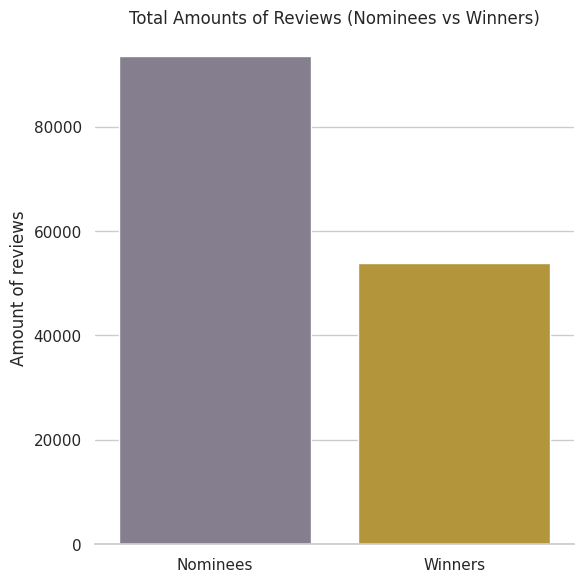

In [115]:
sns.set_theme(style="whitegrid")
colors = ["#847B91", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
g = sns.catplot(data=df_1, kind='bar', x='Won_Oscars', y='Dates',hue='Won_Oscars', errorbar="ci", height=6).set(title='Total Amounts of Reviews (Nominees vs Winners)')
g.despine(left=True)
g.set_axis_labels("", "Amount of reviews")

## Separating the Winners and Nominees and placing them into different data sets

In [116]:
#we separate the winners from the nominated
df = pd.read_csv('merged.csv', low_memory=False)
df_winners = df.loc[df.Oscars_Won>=1]
df_winners_1 = df.loc[df.Oscars_Won==1] #these are winners of 1 Oscar
df_winners_2 = df.loc[df.Oscars_Won>=2] #these are winners of more than 1 Oscar
df_nominees = df.loc[df.Oscars_Won==0]

In [117]:
#we remove the movies with no reviews
df = df[df['Review_Date'] != '[nan]']
df_winners = df_winners[df_winners['Review_Date'] != '[nan]']
df_nominees = df_nominees[df_nominees['Review_Date'] != '[nan]']
df_winners_1 = df_winners_1[df_winners_1['Review_Date'] != '[nan]']
df_winners_2 = df_winners_2[df_winners_2['Review_Date'] != '[nan]']

## Boxplots of the amounts of reviews

In [118]:
#we have one dataframe for the winners and another for the nominees. Again we extract the dates from the lists in the merged dataframe:
df_win = df_dates_reformatting(df_winners)
df_nom = df_dates_reformatting(df_nominees)

[Text(0.5, 1.0, 'Boxplots of Amounts of Reviews (Nominees vs Winners)'),
 Text(0, 0.5, 'Number of Reviews')]

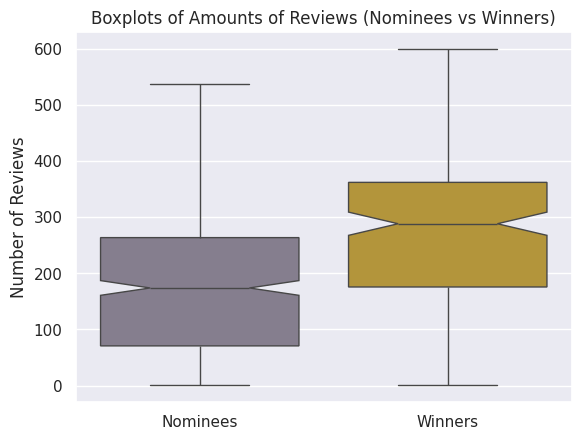

In [119]:
########   Boxplots ---- winners vs nominees  ########
df_box_n = df_nom.groupby(['Movie Title']).count()
df_box_w = df_win.groupby(['Movie Title']).count()

data = pd.DataFrame({'Nominees':df_box_n.loc[:,'Dates'],'Winners':df_box_w.loc[:,'Dates']})
sns.set_theme(style="darkgrid")
colors = ["#847B91", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=data, notch=True, showfliers=False).set(title='Boxplots of Amounts of Reviews (Nominees vs Winners)', ylabel = 'Number of Reviews')

In [120]:
#now we use our date extraction function again, but for the two different types of winners:
df_win1 = df_dates_reformatting(df_winners_1)
df_win2 = df_dates_reformatting(df_winners_2)

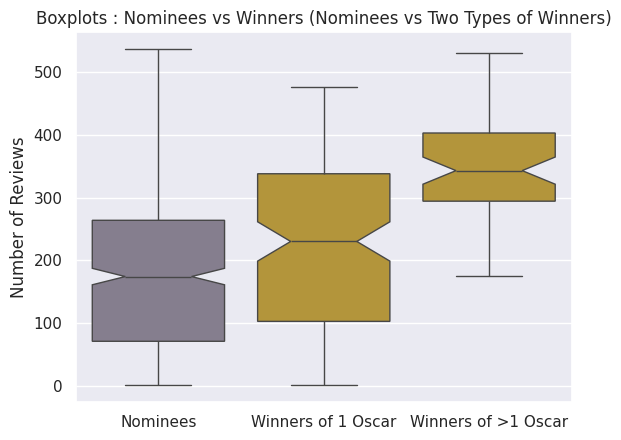

In [122]:
#########  Boxplots ---- winners of 1 or more than 1 oscar vs nominees  #########
df_box_n = df_nom.groupby(['Movie Title']).count()
df_box_w1 = df_win1.groupby(['Movie Title']).count()
df_box_w2 = df_win2.groupby(['Movie Title']).count()

data = pd.DataFrame({'Nominees':df_box_n.loc[:,'Dates'],'Winners of 1 Oscar':df_box_w1.loc[:,'Dates'], 'Winners of >1 Oscar':df_box_w2.loc[:,'Dates']})
sns.set_theme(style="darkgrid")
colors = ["#847B91", "#C79F27", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
g = sns.boxplot(data=data, notch=True, showfliers=False).set(title='Boxplots : Nominees vs Winners (Nominees vs Two Types of Winners)', ylabel = 'Number of Reviews',)

## Boxplots - Amounts of Reviews at 0-3 months, 3-6 months and 6-12 months

We yet again take the dataset which resulted from our dates reformatting function and this time we merge onto this dataset the columns 'Movie Title', 'Won_Oscars' and 'Released' (which contains the release dates of the movies)

In [138]:
df_oscars =  pd.merge(df_result,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')

In [139]:
df_oscars

,Movie Title,Dates,Won_Oscars,Released
0,12 Years a Slave,2013-08-31,True,2013-11-08
1,12 Years a Slave,2013-08-31,True,2013-11-08
2,12 Years a Slave,2013-08-31,True,2013-11-08
3,12 Years a Slave,2013-09-01,True,2013-11-08
4,12 Years a Slave,2013-09-03,True,2013-11-08
...,...,...,...,...
147411,Zootopia,2021-08-29,True,2016-03-04
147412,Zootopia,2021-10-09,True,2016-03-04
147413,Zootopia,2022-04-18,True,2016-03-04
147414,Zootopia,2022-05-16,True,2016-03-04


In [140]:
#we create columns to contain the start and end dates of each period and the counts of the reviews for each one. 
df_oscars.insert(4,'three_months', '')
df_oscars.insert(5,'six_months', '')
df_oscars.insert(6,'twelve_months', '')
df_oscars.insert(7,'0-3 months', '')
df_oscars.insert(8,'3-6 months', '')
df_oscars.insert(9,'6-12 months', '')

In [141]:
df_oscars.head()

,Movie Title,Dates,Won_Oscars,Released,three_months,six_months,twelve_months,0-3 months,3-6 months,6-12 months
0,12 Years a Slave,2013-08-31,True,2013-11-08,,,,,,
1,12 Years a Slave,2013-08-31,True,2013-11-08,,,,,,
2,12 Years a Slave,2013-08-31,True,2013-11-08,,,,,,
3,12 Years a Slave,2013-09-01,True,2013-11-08,,,,,,
4,12 Years a Slave,2013-09-03,True,2013-11-08,,,,,,


In [142]:
sam_osc = df_oscars.iloc[0:50,:]

If we directly try to change the Release dates to datetime, this creates huge issues with the Release dates.

We have to use iterrows() and create a new function :

In [143]:
def df_dates_reformating_and_ranges (df):
    '''Creating ranges and counting occurances for each time range for each movie. This will be used for further plotting'''
    
    #defining start and end dates for each period:
    for row_index, row in df.iterrows(): 
        df.loc[row_index,'three_months'] = datetime.strptime(row['Released'],'%Y-%m-%d').date() + pd.DateOffset(months=3)
        df.loc[row_index,'six_months'] = datetime.strptime(row['Released'],'%Y-%m-%d').date() + pd.DateOffset(months=6)
        df.loc[row_index,'twelve_months'] = datetime.strptime(row['Released'],'%Y-%m-%d').date() + pd.DateOffset(months=12)

        #counting each occurance 
        if df.loc[row_index,'Dates'] <= df.loc[row_index,'three_months']:
            df.loc[row_index,'0-3 months'] = 1
            df.loc[row_index,'3-6 months'] = 0
            df.loc[row_index,'6-12 months'] = 0
            three_list=[]
        elif (df.loc[row_index,'Dates'] >= df.loc[row_index,'three_months'])&(df.loc[row_index,'Dates'] <= df.loc[row_index,'six_months']): 
            df.loc[row_index,'0-3 months'] = 0
            df.loc[row_index,'3-6 months'] = 1
            df.loc[row_index,'6-12 months'] = 0
            six_list=[]
        elif (df.loc[row_index,'Dates'] >= df.loc[row_index,'six_months'])&(df.loc[row_index,'Dates'] <= df.loc[row_index,'twelve_months']):
            df.loc[row_index,'0-3 months'] = 0
            df.loc[row_index,'3-6 months'] = 0
            df.loc[row_index,'6-12 months'] = 1
            twelve_list=[]
        else:
            df.loc[row_index,'0-3 months'] = 0
            df.loc[row_index,'3-6 months'] = 0
            df.loc[row_index,'6-12 months'] = 0
            
    
    return (df)
df_red= df_dates_reformating_and_ranges (df_oscars)
df_red.head()

,Movie Title,Dates,Won_Oscars,Released,three_months,six_months,twelve_months,0-3 months,3-6 months,6-12 months
0,12 Years a Slave,2013-08-31,True,2013-11-08,2014-02-08 00:00:00,2014-05-08 00:00:00,2014-11-08 00:00:00,1,0,0
1,12 Years a Slave,2013-08-31,True,2013-11-08,2014-02-08 00:00:00,2014-05-08 00:00:00,2014-11-08 00:00:00,1,0,0
2,12 Years a Slave,2013-08-31,True,2013-11-08,2014-02-08 00:00:00,2014-05-08 00:00:00,2014-11-08 00:00:00,1,0,0
3,12 Years a Slave,2013-09-01,True,2013-11-08,2014-02-08 00:00:00,2014-05-08 00:00:00,2014-11-08 00:00:00,1,0,0
4,12 Years a Slave,2013-09-03,True,2013-11-08,2014-02-08 00:00:00,2014-05-08 00:00:00,2014-11-08 00:00:00,1,0,0


## Barplots for the means for each category at 0-3 months, 3-6 months, 6-12 months

In [144]:
df_red['Won_Oscars'] = df_red['Won_Oscars'].astype(str)
df_red.replace({'False': 'Nominee', 'True': 'Winner'}, inplace=True)
df_red = df_red.groupby(['Won_Oscars','Movie Title']).agg({'0-3 months':'sum', '3-6 months':'sum', '6-12 months':'sum'})
df_red_totals = df_red.groupby('Won_Oscars')[['0-3 months', '3-6 months', '6-12 months']].sum()

/tmp/ipykernel_61559/4200686916.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_red.replace({'False': 'Nominee', 'True': 'Winner'}, inplace=True)


In [145]:
df_red_totals.iloc[0,:] = df_red_totals.iloc[0,:] / 532 #divide by the total amount of nominees so we get an average
df_red_totals.iloc[1,:] = df_red_totals.iloc[1,:] / 319 #divide by the total amount of winners so we get an average

/tmp/ipykernel_61559/1978266864.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '135.48496240601503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_red_totals.iloc[0,:] = df_red_totals.iloc[0,:] / 532 #divide by the total amount of nominees so we get an average
/tmp/ipykernel_61559/1978266864.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.411654135338345' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_red_totals.iloc[0,:] = df_red_totals.iloc[0,:] / 532 #divide by the total amount of nominees so we get an average
/tmp/ipykernel_61559/1978266864.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.071428571428571' has dtype incompatible with 

In [146]:
df_red_totals

,0-3 months,3-6 months,6-12 months
Won_Oscars,,,
Nominee,135.484962,9.411654,10.071429
Winner,130.423197,7.755486,8.266458


[Text(0.5, 1.0, 'Normalized Number of Reviews for each Category'),
 Text(0, 0.5, 'Number of Reviews'),
 Text(0.5, 0, '')]

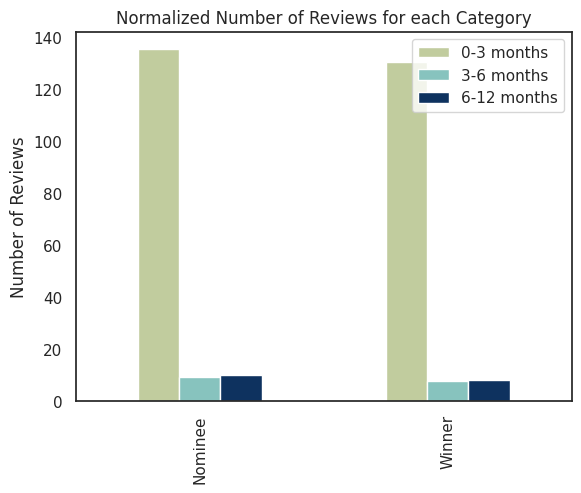

In [147]:
sns.set_theme(style="white")
df_red_totals.plot(kind='bar', color = ["#C1CC9E",'#87C3BE',"#0E325F"]).set(title='Normalized Number of Reviews for each Category', ylabel = 'Number of Reviews', xlabel='')

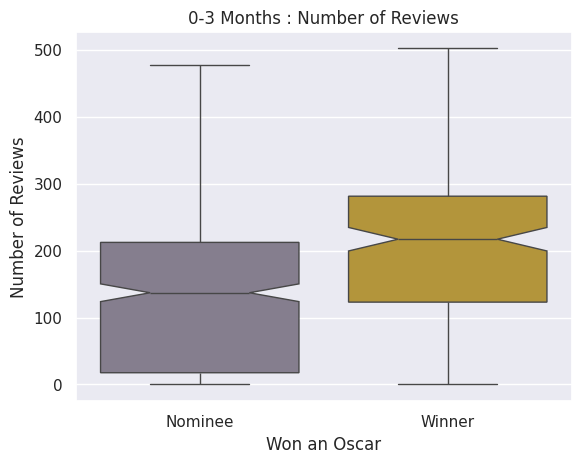

In [148]:
# boxplots for 0-3 months 
sns.set_theme(style="darkgrid")
colors = ["#847B91", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
#data = pd.DataFrame({'Nominees':df_red.iloc[0],'Winners':df_red.iloc[1]})
g = sns.boxplot(data=df_red, x='Won_Oscars', y= '0-3 months',notch=True, hue = 'Won_Oscars', showfliers=False).set(title='0-3 Months : Number of Reviews', ylabel = 'Number of Reviews', xlabel ='Won an Oscar')

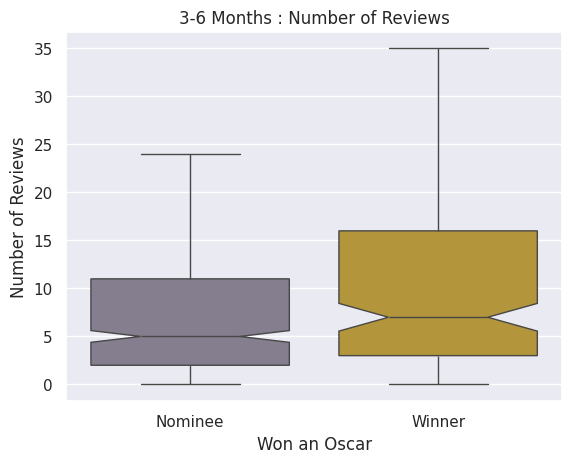

In [149]:
# boxplots for 3-6 months 
sns.set_theme(style="darkgrid")
colors = ["#847B91", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
g = sns.boxplot(data=df_red, x='Won_Oscars', y= '3-6 months',notch=True, hue = 'Won_Oscars',showfliers=False).set(title='3-6 Months : Number of Reviews', ylabel = 'Number of Reviews', xlabel ='Won an Oscar')

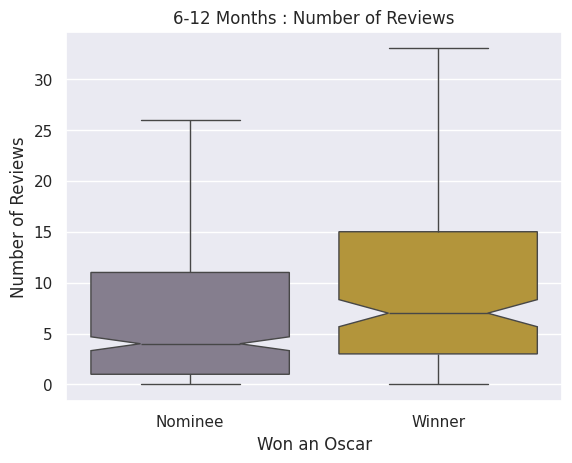

In [151]:
# boxplots for 6-12 months 
sns.set_theme(style="darkgrid")
colors = ["#847B91", "#C79F27"]
sns.set_palette(sns.color_palette(colors))
g = sns.boxplot(data=df_red, x='Won_Oscars', y= '6-12 months',notch=True, hue = 'Won_Oscars',showfliers=False).set(title='6-12 Months : Number of Reviews', ylabel = 'Number of Reviews', xlabel ='Won an Oscar')

## EXTRA CODE

In [ ]:
#unique_count = df_oscars[df_oscars['Won_Oscars'] == False].count()
#unique_count

In [ ]:
#df_oscars =  pd.merge(df_result,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')
#df_win =  pd.merge(df_win,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')
#df_win1 = pd.merge(df_win1,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')
#df_win2 = pd.merge(df_win2,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')
#df_nom =  pd.merge(df_nom,df[['Movie Title','Won_Oscars', 'Released']],on='Movie Title', how='left')

In [ ]:
#df_sam.loc[:, 'three_months'] = df_sam.loc[:,'Dates'] + pd.DateOffset(months=3)

#df_sam.three_months = df_sam.Released + pd.DateOffset(months=3)
#df_sam.six_months = df_sam.Released + pd.DateOffset(months=6)
#df_sam.twelve_months = df_sam.Released + pd.DateOffset(months=12)

In [172]:
df_oscars.groupby(df_oscars['Dates'].dt.to_period('Q'))['count'].sum()

Dates
2005Q4       1
2006Q3      37
2006Q4       3
2007Q2       2
2007Q3       6
          ... 
2023Q2    1914
2023Q3    3220
2023Q4    3339
2024Q1    1461
2024Q2      75
Freq: Q-DEC, Name: count, Length: 72, dtype: int64

In [145]:
df_p = df_sample.groupby(pd.to_datetime(df_sample['Dates'], format='%b-%Y').dt.to_period('Q'))['Movie Title'].count()

In [146]:
#df_p = pd.DataFrame(df_p)
df_p

Dates
2010Q3     13
2010Q4    108
2013Q3     29
2013Q4    180
2014Q1     44
2014Q2      2
2014Q3      4
2014Q4      1
2015Q1     25
2015Q2      1
2015Q3      1
2015Q4      1
2016Q1      7
2016Q2      4
2016Q3      1
2017Q1     10
2017Q3      3
2017Q4      2
2018Q1     18
2018Q3      6
2018Q4      4
2019Q1      4
2019Q2      4
2019Q3      4
2019Q4      1
2020Q2      2
2020Q3      4
2020Q4      1
2021Q1      5
2021Q3      2
2022Q1      2
2022Q2      1
2022Q3      2
2023Q1      1
2023Q2      2
2024Q1      1
Freq: Q-DEC, Name: Movie Title, dtype: int64

In [195]:
new_df = pd.DataFrame(new_list, columns=['Dates'])
def getLabels(new_df):
    labels =[]
    for x in pd.date_range(start='2019-07-01', end='2024-01-27', freq='3M'):
        labels.append(str(x).replace(" 00:00:00",""))
    return labels
labels = getLabels(new_df)
labels

/tmp/ipykernel_2331/3180660478.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for x in pd.date_range(start='2019-07-01', end='2024-01-27', freq='3M'):


['2019-07-31',
 '2019-10-31',
 '2020-01-31',
 '2020-04-30',
 '2020-07-31',
 '2020-10-31',
 '2021-01-31',
 '2021-04-30',
 '2021-07-31',
 '2021-10-31',
 '2022-01-31',
 '2022-04-30',
 '2022-07-31',
 '2022-10-31',
 '2023-01-31',
 '2023-04-30',
 '2023-07-31',
 '2023-10-31']

In [ ]:

# EXTRA CODE
df['Critic_Review'] = df.apply(lambda x: f'{x['Author']} from {x['Journal']}: {x['Reviews']}', axis=1)
df.drop( ['Reviews','Journal','Outlier_Reviews_Amount_(True/False)','Reviews'], axis=1,inplace= True)
positive_negative_counts = pf.get_dummies(df['Positive_Negative'].groupby(df['Movie_Title']).sum().reset_index()
combined_reviews= df.groupby('Movie_Title')['Critic_Review'].apply(lambda x:' | '.join(x)).reset_index()
list_of_review_dates = df.groupby('Movie_Title').agg({'Review_Date' : lambda x: list(x)}).reset_index()
df_step = pd.merge(combined_reviews, positive_negative_counts, on='Movie_Title')
df_step = pf.merge(df_step, list_of_review_dates, on='Movie_Title')
aggregated_df_B = df_B.groupby('Movie_Title').first().reset_index()
df_B = pd.merge(aggregated_df_B, df_step, on = 'Movie_Title')
df_merged_cb = pd.merge(df_C, df_B, on='Title', how='outer')
final_df = pd.merge(df_merged_cb, df_A, on='Title', how='outer')

In [ ]:
df_A.insert(1,'Nominees', True)
df_A.insert(1,'Won 1 Oscar', True)
df_A.insert(1,'Won 2 or more Oscars', True)

def find_winners_nominees (df_A):
    count_nominee = 0
    count_1_win = 0
    count_2_win = 0
    #diff_count = 0
    for row_index, row in df_A.iterrows(): 
        if str(row[2:36]) == 'Nominated' and str(row[2:36]) != 'Winner':
            row['Nominees'] = True 
        elif str(row[2:36]) != 'Winner':
        diff_count = diff_count+1
            if diff_count >= 2:
                row['Won 2 or more Oscars'] = True
            else :
                row['Won 1 Oscar'] = True
df_A = find_winners_nominees(df_A)
df_A

In [319]:
df = pd.read_csv('merged.csv', low_memory=False)

RangeIndex(start=0, stop=851, step=1)

In [ ]:
#### Engagement Analysis ####
from datetime import datetime
#from datetime import datetime, date
#import datetime
from dateutil import parser
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

#we separate the winners from the nominated
df = pd.read_csv('merged.csv', low_memory=False)
df_winners = df.loc[df.Oscars_Won>=1]
df_winners_1 = df.loc[df.Oscars_Won==1]
df_winners_2 = df.loc[df.Oscars_Won>=2]
df_nominees = df.loc[df.Oscars_Won==0]

# We plot the amounts of reviews over time for the outlier movie with the most reviews (Joker, 2019) 

#First we extract the dates in the cell for review dates:
Joker_data = df.loc[df['Movie Title']=='Joker']
Jojo_Rabbit_data =df.loc[df['Movie Title']=='Jojo Rabbit']
list = [date for date in str(Joker_data['Review_Date']).split(',')]
list2 = [date for date in str(Jojo_Rabbit_data['Review_Date']).split(',')]




new_list=[]
for time in list2:
    match = re.search(r'\d{4}-\d{2}-\d{2}', time)
    try:
        match= match.group()
        match= datetime.strptime(match,'%Y-%m-%d').date()
    except AttributeError:
        continue
    #match = pd.to_datetime(match, errors='coerce')
    new_list.append(match)
new_list

new_df = pd.DataFrame(new_list, columns=['Dates'])

#today = datetime.date.today()
#new_df['days ago'] = (today - new_df['Dates']).dt.months
#new_df['Dates'] = pd.to_datetime(new_df['Dates'])
#s =  (pd.to_datetime('today').normalize() - new_df['Dates']).datetime.month
#new_df['Date_Bin'] = pd.cut(s, [0, 6, 12, 18, 24, 30, 36,42, np.inf])

my_plot = sns.histplot(data=new_list, bins=20, kde=True)
my_plot.set_ylim(0, 21)
#my_plot.set_xlim(datetime.date(2021, 1, 1))
#my_plot.autofmt_xdate()
#my_plot.set_xticklabels(labels, freq="QE"), rotation=45)
  
#new_df = pd.DataFrame(new_list, columns=['Dates'])
#group = new_df.groupby('Dates').size().reset_index()
#group = group.sort_values('Dates')
#group.rename({0:'count'}, axis = 'columns', inplace = True)
#fig = px.bar(x='Dates', y = 'count')
#fig.show()
#plt.show()
#sns.scatterplot(new_list)
    #parser.parse(time,fuzzy=True)
    #date_obj = datetime.strptime(time, date_format)
    #print(date_obj)


In [ ]:
df_red_ex.astype({'0-3 months':int, '3-6 months':int, '6-12 months':int})